<h1 align=center><font size = 5>SPE Europe Energy GeoHackathon</font></h1>

Society of Petroleum Engieers|  ERCE Equipoise | Geothermal Challenge  
:-------------------------:|:-------------------------:|:-------------------------:
<a href="https://www.spehackathon-eu.com"> <img src = "https://upload.wikimedia.org/wikipedia/en/thumb/4/42/Society_of_Petroleum_Engineers_Logo.svg/1200px-Society_of_Petroleum_Engineers_Logo.svg.png" width = 200 /> | <a href="https://www.erce.energy/"> <img src = "https://energycouncil.com/wp-content/uploads/ERCE.png" width = 200/> | <img src = "https://solutions.vallourec.com/-/media/Solutions-img/Low-Carbon-Energy/Medias/Geothermal-energy/Header-Corner_Geothermal.ashx" width = 200/>
    


<h1 align=center><font size = 4> Team ERCE - Munish Kumar, Kanna Swaminathan & Ivan Maulana </font></h1>
<h1 align=center><font size = 3> 2021 </font></h1>

In [1]:
#!pip install openpyxl

In [2]:
# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
import math

import time
import re
import requests
import pickle
import os
import glob
import scipy
import sys
import warnings

import plotly.express as px
import plotly.graph_objects as go 

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

warnings.filterwarnings('ignore')
sns.set()

from sklearn.linear_model import LinearRegression

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [3]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Working\SPE_GeoHackathon\4_Submission_14122021\Sect3.4_DARTS'
filename_suffix = 'txt'
filename_suffix2 = 'csv'
filename_suffix3 = 'xlsx'

font = {'family': 'arial',
    'color':  'blue',
    'weight': 'normal',
    'size': 16,
   }

### The following code cleans up and prepares the output excel sheet for economic modelling

In [4]:
#Read and load data
def interp_well(dir_name, base_filename, filename_suffix, font):
    skiprows = 0
    csvs_sht = os.path.join(dir_name, base_filename + '.' + filename_suffix)   
    data = pd.read_excel(csvs_sht, skiprows = skiprows, header=0)
    data.columns = map(str.lower, data.columns)
    
    # We are reusing the exploration wells.
    data.columns = data.columns.str.replace('e03','i04')
    data.columns = data.columns.str.replace('e02','i05')
    data.columns = data.columns.str.replace('e04','i06')
    #data.columns = data.columns.str.replace('e05','i07')
    #data.columns = data.columns.str.replace('e01','i08')
    data.columns = data.columns.str.replace('e06','i09')
    
    #Check the data
    print("------------------Checking the Data---------------")   
    print(data.head())
    print("------------------Type of Data---------------")   
    print(data.info())
    
    df1 = data_cleanup(data)
    
    print("---------------------Name of Columns Present---------------------")
    print(df1.columns.tolist())
    print("---------------------Check for Unique Column Names---------------------")
    print(df1.info())
    
    # Output
    final_filename = '_mod'
    csvs_sht0 = os.path.join(dir_name, base_filename + final_filename + '.' + filename_suffix2)
    print("---------------Write out File---------------")
    df1.to_csv(csvs_sht0, index = False, header=True)
    
    return df1

In [5]:
# Drop columns that are not required
def data_cleanup(data):
       
    press_gridcells = data.filter(like='reservoir').columns.tolist()
    chem_cols = data.filter(like='kmol').columns.tolist()
    time = data.filter(like='time').columns.tolist()

    # remove columns from data
    data.drop(columns=press_gridcells + chem_cols, inplace=True)
    
    # time is currently in days, convert to years
    data['time (yrs)']= data['time']/365
    #data.drop(columns=time, inplace=True)
    
    # filtering on the basis of columns where the sum is greater than 0
    data_new = data.loc[:, data.sum(axis = 0) != 0]
    
    print("---------------------Before Time Modification---------------------")
    crossplot(data_new)
    data_time_mod = assigntime(data_new)
    
    print("---------------------After Time Modification---------------------")
    crossplot(data_time_mod)

    return data_time_mod

In [6]:
def crossplot(data):
    # overview plot of data
    fig, ax = plt.subplots(2,2, figsize=(12,6), dpi=150, sharex=True)
    # get plot axes
    ax_list = fig.axes

    # plot a few keywords in pairs for both wells
    for i, key in enumerate(['temperature (k)', 'bhp (bar)','energy (kj/day)','water rate (m3/day)']):
        data.plot(x='time (yrs)',
                 y=data.filter(like=key).columns.tolist(), 
                 ax=ax_list[i], 
                 linestyle='-', 
                 style=['x', 'o'])
        ax_list[i].legend(fontsize=6)
        ax_list[i].grid(alpha=0.3)

    plt.show()
    return

In [7]:
# The following code block is to change the time format and create it as a index
def assigntime(data):

    # assign datetime as index
    data['datetime'] = pd.to_datetime('1/1/2000') + pd.to_timedelta(
        data['time (yrs)'] * pd.Timedelta(('365 days')), unit='s')
    data.set_index('datetime', inplace=True)

    # set the new time interval
    set_interval = '365D'

    # generate the new index on which the data should correspond based on original index range
    resample_index = pd.date_range(data.index[0] - pd.Timedelta(set_interval),
                                   data.index[-1] + pd.Timedelta(set_interval), freq=set_interval, normalize=True,
                                   closed='right')
    
    # create a new index as the union of the old and new index and interpolate on the combined index
    # then reindex the dataframe to the new index
    tdata = data.reindex(data.index.union(resample_index)).interpolate('index').reindex(resample_index)

    # maintain initial values of original dataset in the newly indexed one at the edges
    tdata.iloc[0] = data.iloc[0]
    tdata.iloc[-1] = data.iloc[-1]

    # add the number of periods for further economic assessment
    tdata['econ_periods'] = np.arange(len(tdata))
    
    # compute the deltahours for economic and energy assessments
    tdata['deltahours'] = tdata.index.to_series().diff(1) / pd.Timedelta('1 hour')

    # verify that we only have one delta
    tdata['deltahours'].unique()
    
    # recompute time columns based on index
    tdata['time (yrs)'] = pd.to_timedelta(tdata.index - tdata.index[0]).total_seconds() / (365 * 24 * 60 * 60)

    # reset index to time delta
    tdata.set_index(pd.to_timedelta(tdata['time (yrs)'] * pd.Timedelta(('365 days')), unit='s'), inplace=True)
    tdata.drop(columns='time', inplace=True)
    
    return tdata

------------------Checking the Data---------------
   unnamed: 0  fips c 0 (kmol)  p10 : p 19 c 0 rate (kmol/day)  \
0           0     4.479892e+18                   -8.991560e+07   
1           1     4.479892e+18                   -2.139214e+08   
2           2     4.479892e+18                   -2.132606e+08   
3           3     4.479892e+18                   -1.987788e+08   
4           4     4.479892e+18                   -1.434432e+08   

   p10 : p 18 c 1 rate (kmol/day)  p10 : p 18 reservoir p (bar)  \
0                    -2914.945694                    180.041216   
1                    -7433.156172                    180.038384   
2                    -7481.094397                    179.989225   
3                    -7521.750137                    178.903995   
4                    -6065.046631                    172.231890   

   p10 : p 17 reservoir p (bar)  p10 : p 17 c 1 rate (kmol/day)  \
0                    179.306153                    -9605.382112   
1              

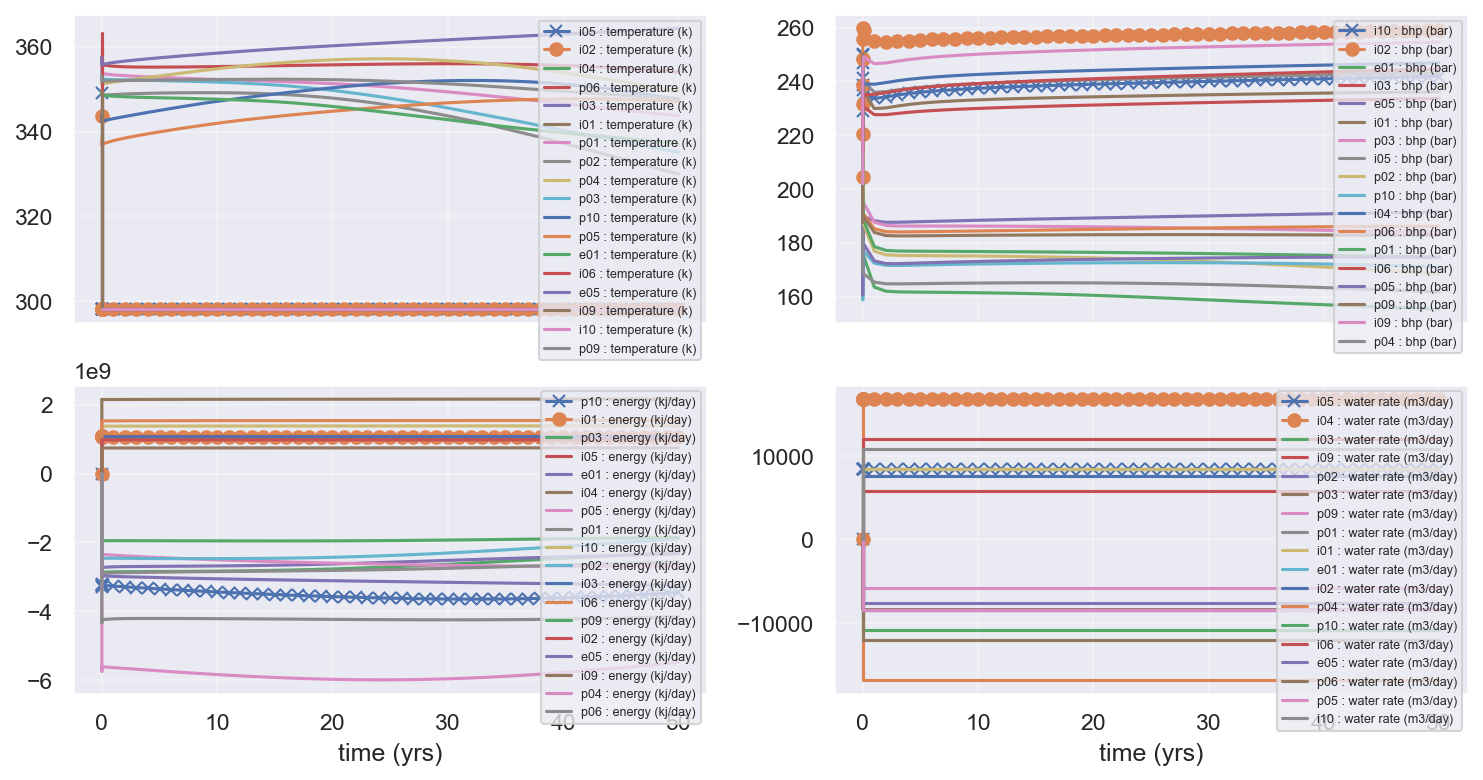

---------------------After Time Modification---------------------


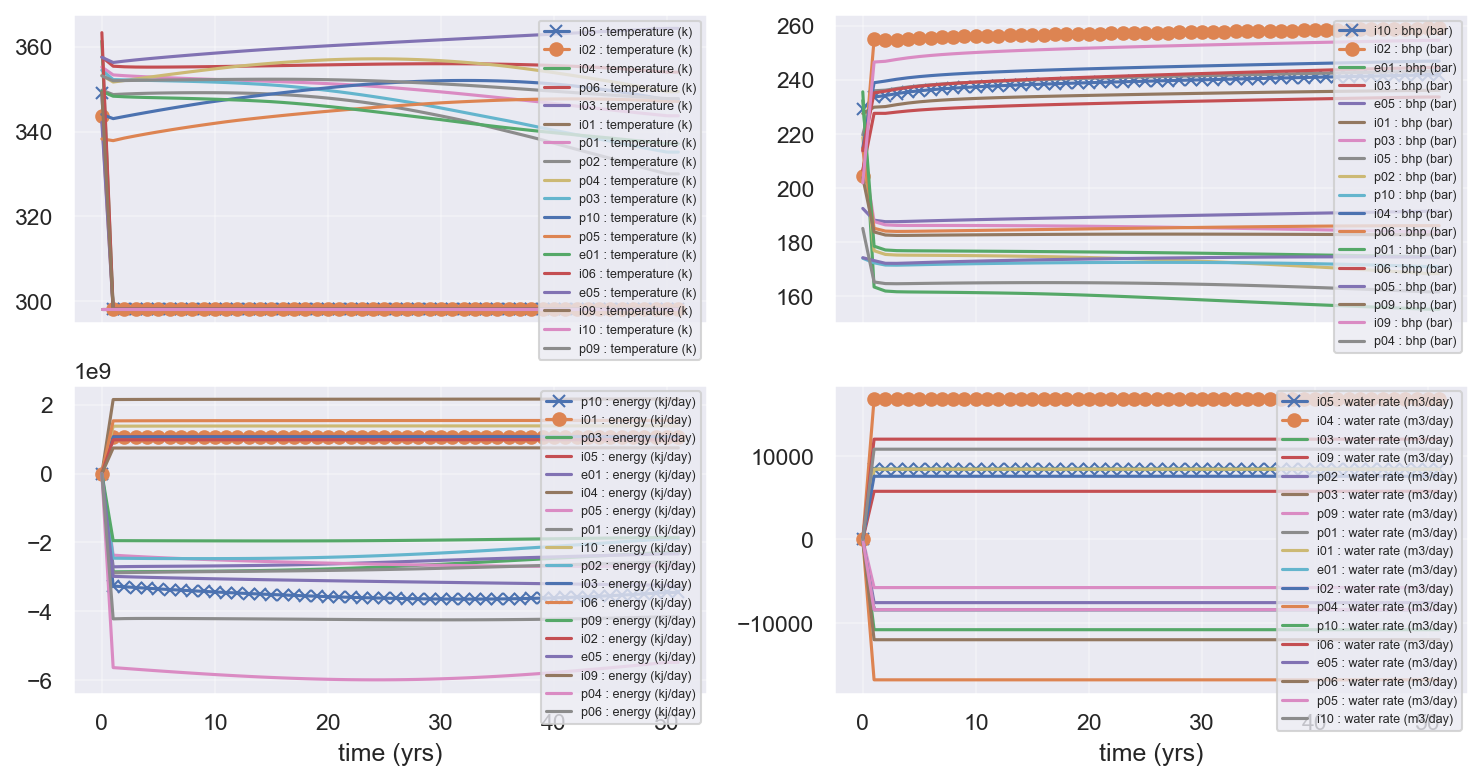

---------------------Name of Columns Present---------------------
['unnamed: 0', 'p10 : energy (kj/day)', 'i10 : bhp (bar)', 'i01 : energy (kj/day)', 'p03 : energy (kj/day)', 'i05 : energy (kj/day)', 'i05 : temperature (k)', 'i05 : water rate (m3/day)', 'i04 : water rate (m3/day)', 'i02 : temperature (k)', 'i03 : water rate (m3/day)', 'i02 : bhp (bar)', 'e01 : energy (kj/day)', 'i09 : water rate (m3/day)', 'p02 : water rate (m3/day)', 'p03 : water rate (m3/day)', 'e01 : bhp (bar)', 'i04 : energy (kj/day)', 'p05 : energy (kj/day)', 'i03 : bhp (bar)', 'p09 : water rate (m3/day)', 'i04 : temperature (k)', 'p06 : temperature (k)', 'i03 : temperature (k)', 'i01 : temperature (k)', 'e05 : bhp (bar)', 'p01 : energy (kj/day)', 'p01 : water rate (m3/day)', 'i01 : bhp (bar)', 'p01 : temperature (k)', 'i10 : energy (kj/day)', 'i01 : water rate (m3/day)', 'e01 : water rate (m3/day)', 'p03 : bhp (bar)', 'i05 : bhp (bar)', 'i02 : water rate (m3/day)', 'p02 : temperature (k)', 'p04 : water rate (m3/d

In [8]:
base_filename = 'R36_8Db_R24dup_Db04_700_05_10_06_SouthB2_2000'
df1 = interp_well(dir_name, base_filename , filename_suffix3, font)

### Conclusion

In [9]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 5.462781190872192 seconds
